In [9]:
import os
import utilities as rocku
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import timeit
from pystackreg import StackReg
from PIL import Image
import dxchange
from tqdm import tqdm

In [10]:
ncore = mp.cpu_count()
ncore

64

In [3]:
# need to change
ipts="28402"
# scan_type = 'ct_scans'
# scan_type = 'radiographs'
scan_type = 'processed_data/normalized'
# scan_type = 'analysis'
# scan_type = 'analysis'
####################################
##################################
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/" + scan_type
folder_list = os.listdir(scan_loc)
folder_list.sort()
folder_list

['2023_09_06_exsitu',
 '2023_09_06_insitu_60s',
 '2023_09_06_insitu_60s_binned_by_10',
 '2023_09_06_insitu_60s_binned_by_5',
 '2023_09_06_insitu_60s_binned_by_5_left',
 '2023_09_06_insitu_60s_binned_by_5_right',
 '2023_09_07_insitu_60s',
 '2023_09_07_insitu_60s_binned_by_5',
 '2023_09_07_insitu_60s_binned_by_5_left',
 '2023_09_07_insitu_60s_binned_by_5_right']

In [39]:
sample_name = "2023_09_06_insitu_60s_binned_by_5_left"
######################
######################
######################
scan_dir = os.path.join(scan_loc, sample_name)
fname_list = os.listdir(scan_dir)
fname_list.sort()
fname_list

['20230906_cells_t0_0060_0342.tiff',
 '20230906_cells_t0_0060_0347.tiff',
 '20230906_cells_t_cycling_0060_0352.tiff',
 '20230906_cells_t_cycling_0060_0357.tiff',
 '20230906_cells_t_cycling_0060_0362.tiff',
 '20230906_cells_t_cycling_0060_0367.tiff',
 '20230906_cells_t_cycling_0060_0372.tiff',
 '20230906_cells_t_cycling_0060_0377.tiff',
 '20230906_cells_t_cycling_0060_0382.tiff',
 '20230906_cells_t_cycling_0060_0387.tiff',
 '20230906_cells_t_cycling_0060_0392.tiff',
 '20230906_cells_t_cycling_0060_0397.tiff',
 '20230906_cells_t_cycling_0060_0402.tiff',
 '20230906_cells_t_cycling_0060_0407.tiff',
 '20230906_cells_t_cycling_0060_0412.tiff',
 '20230906_cells_t_cycling_0060_0417.tiff',
 '20230906_cells_t_cycling_0060_0422.tiff',
 '20230906_cells_t_cycling_0060_0427.tiff',
 '20230906_cells_t_cycling_0060_0432.tiff',
 '20230906_cells_t_cycling_0060_0437.tiff',
 '20230906_cells_t_cycling_0060_0442.tiff',
 '20230906_cells_t_cycling_0060_0447.tiff',
 '20230906_cells_t_cycling_0060_0452.tiff',
 '

In [40]:
img_stack = rocku.read_img_stack(scan_dir, fname_list, flipud=False)

463it [00:08, 54.99it/s]


In [41]:
trans_algo_dict = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

Text(0.5, 1.0, 'last image')

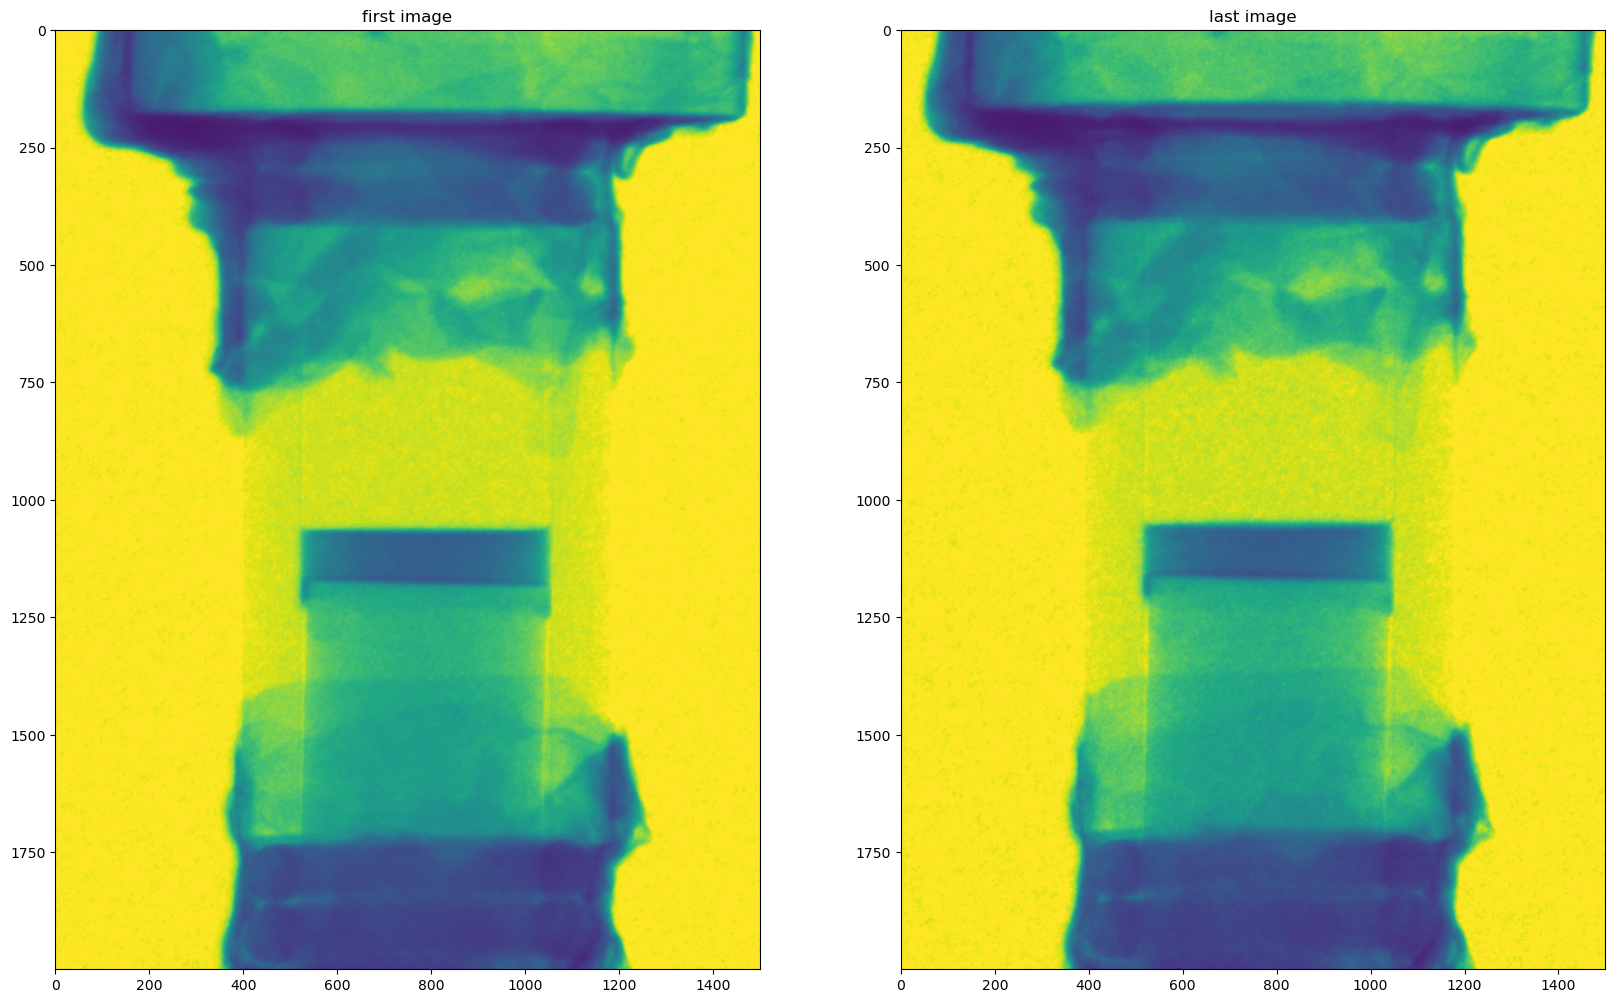

In [42]:
#load reference and "moved" image
ref = img_stack[0]
mov = img_stack[-1]

f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(ref, vmin=0, vmax=1)
ax[0].set_title('first image')

ax[1].imshow(mov, vmin=0, vmax=1)
ax[1].set_title('last image')

Text(0.5, 1.0, 'last image')

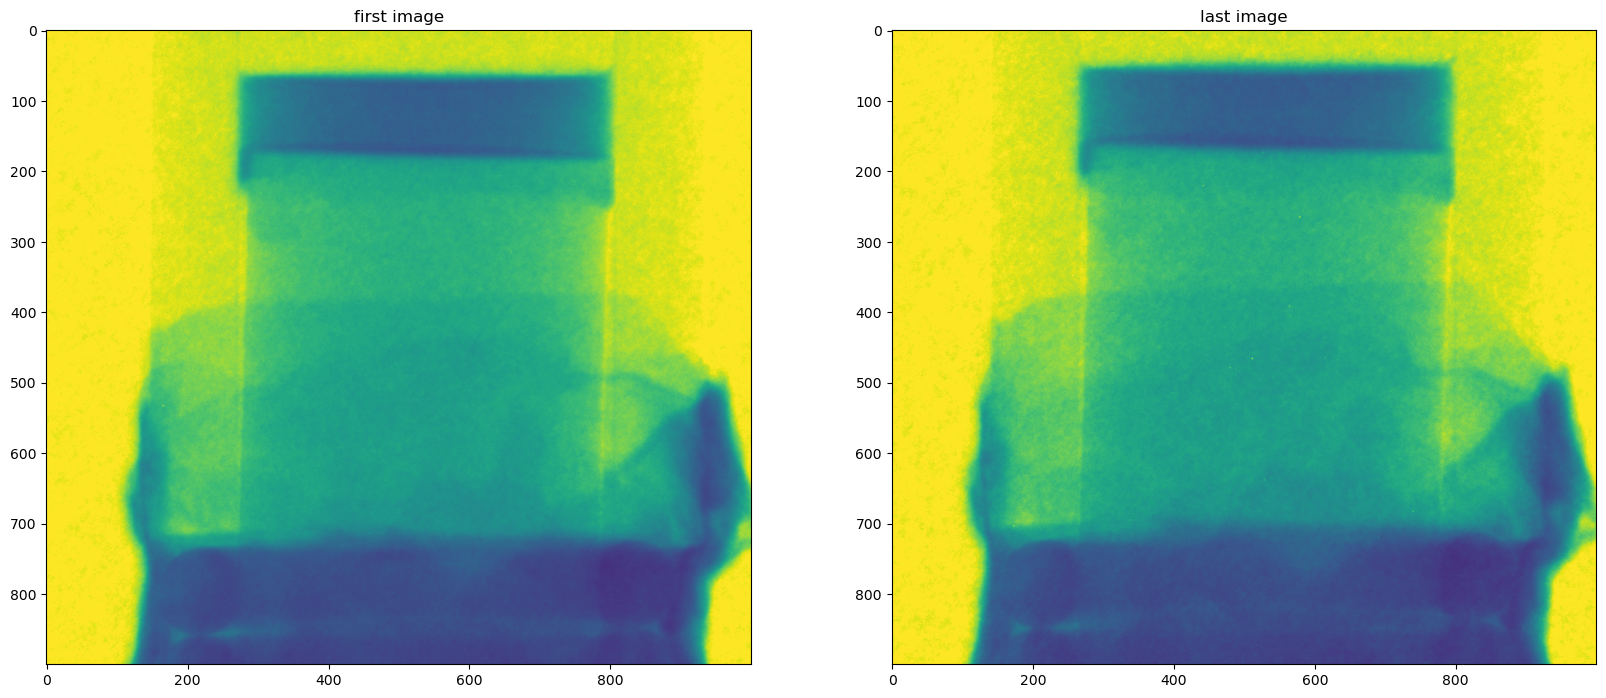

In [53]:
###################### need to change start
roi = True
roi_left = 250
roi_right = 1250
roi_top = 1000
roi_bottom = 1900
###################### need to change end
img_stack_roi = rocku.crop(img_stack, roi_left, roi_right, roi_top, roi_bottom, roi)
ref_roi = img_stack_roi[0]
mov_roi = img_stack_roi[-1]

f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(ref_roi, vmin=0, vmax=1)
ax[0].set_title('first image')

ax[1].imshow(mov_roi, vmin=0, vmax=1)
ax[1].set_title('last image')

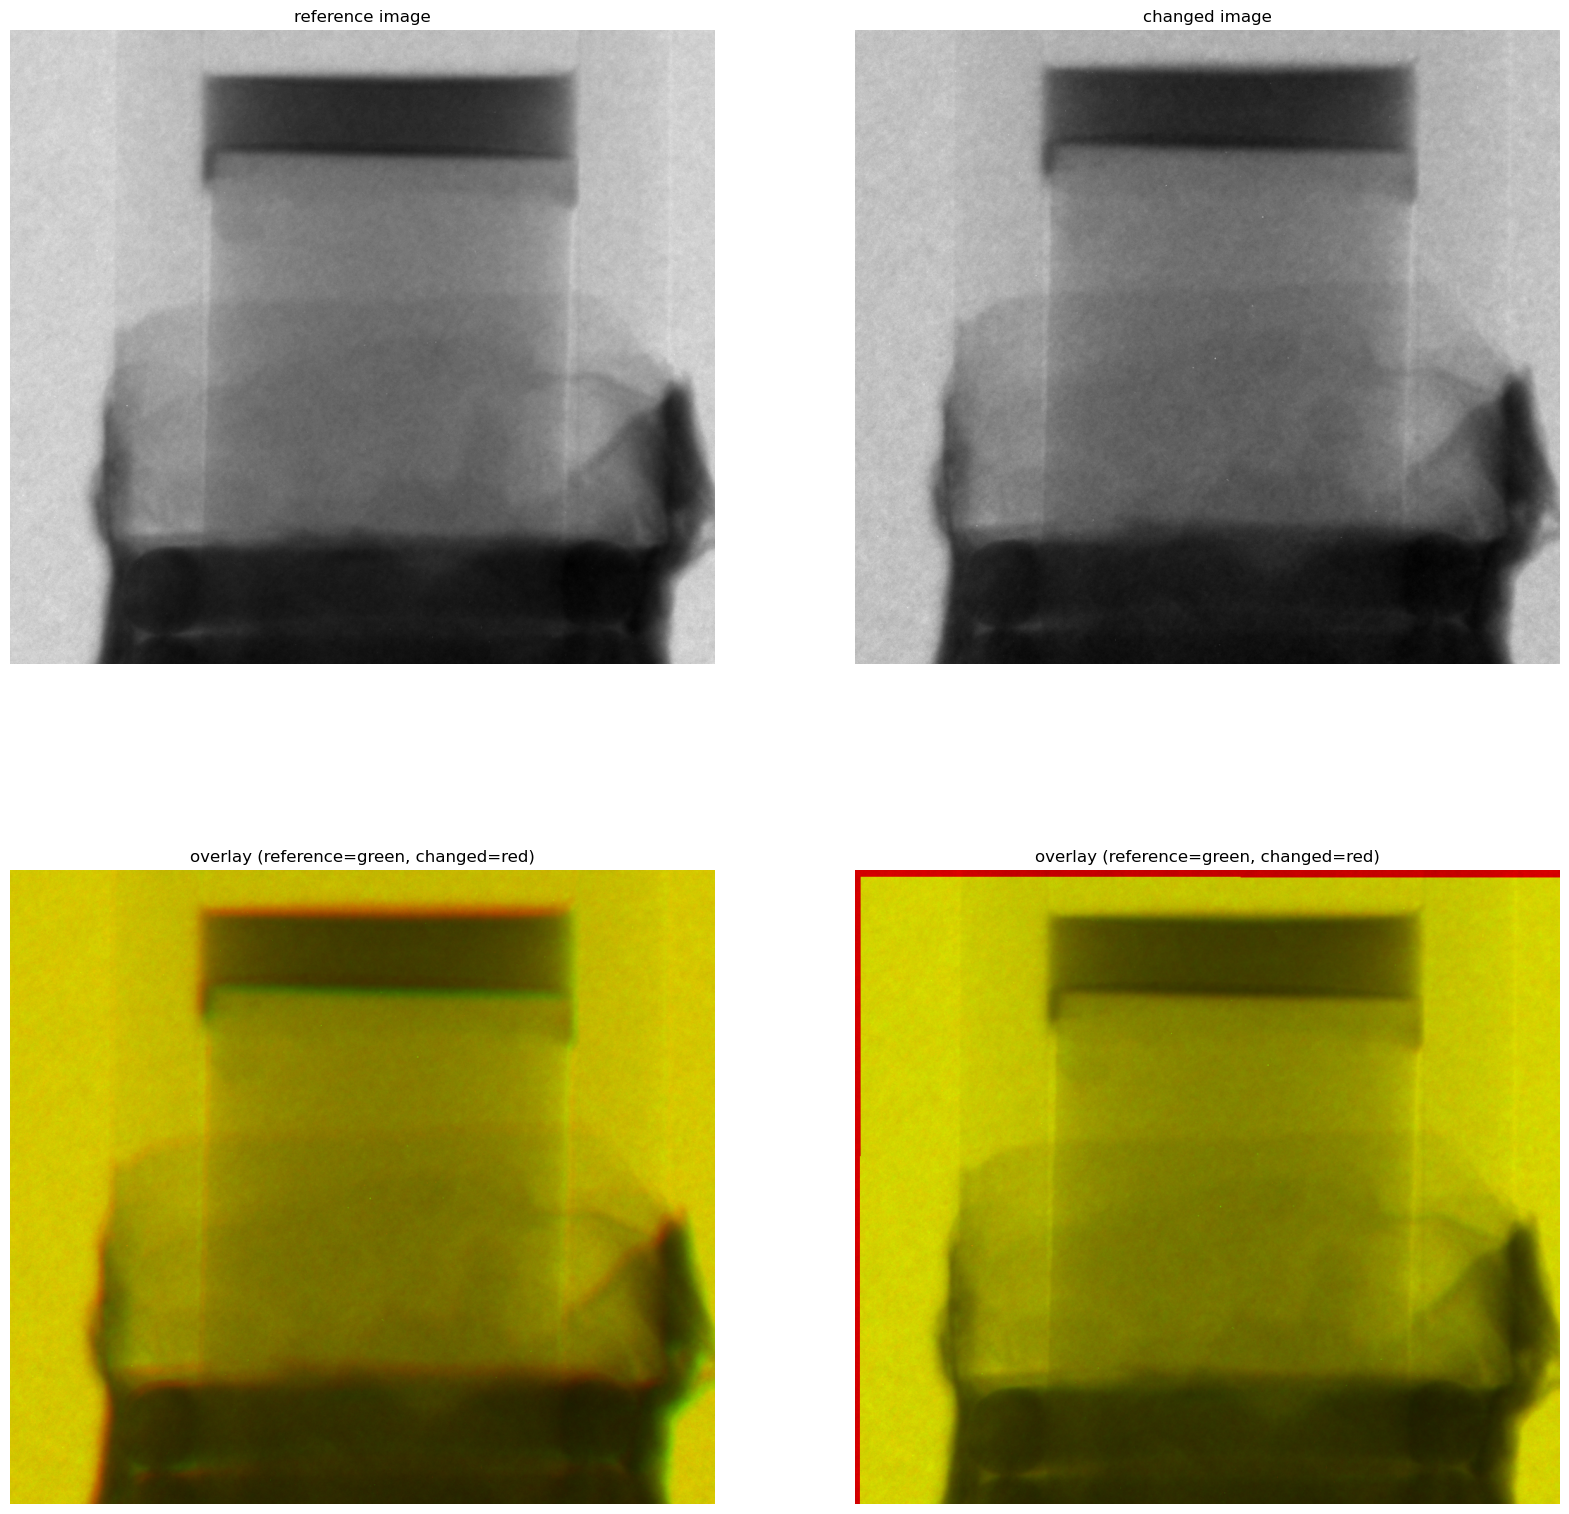

In [54]:
trans_algo = 'RIGID_BODY'
#########################
#########################
sr = StackReg(trans_algo_dict[trans_algo])
reg = sr.register_transform(ref_roi, mov_roi)
reg = reg.clip(min=0)
after_reg = rocku.composite_images([ref_roi, reg])
before_reg = rocku.composite_images([ref_roi, mov_roi])

f, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0][0].imshow(ref_roi, cmap='gray')
ax[0][0].set_title('reference image')
ax[0][0].axis('off')

ax[0][1].imshow(mov_roi, cmap='gray')
ax[0][1].set_title('changed image')
ax[0][1].axis('off')

ax[1][0].imshow(before_reg)
ax[1][0].set_title('overlay (reference=green, changed=red)')
ax[1][0].axis('off');

ax[1][1].imshow(after_reg)
ax[1][1].set_title('overlay (reference=green, changed=red)')
ax[1][1].axis('off');

In [ ]:
sr = StackReg(trans_algo_dict[trans_algo])
size = (img_stack.shape[0], img_stack.shape[1], img_stack.shape[2])

reg_stack = np.empty(size, dtype=img_stack.dtype)
reg_stack[0] = img_stack[0][:]
for idx in tqdm(range(size[0])):
    if idx != 0:
        _reg_roi = sr.register_transform(img_stack_roi[0], img_stack_roi[idx])
        _reg = sr.transform(img_stack[idx])
        _reg = _reg.clip(min=0)
        reg_stack[idx] = _reg[:]

  4%|█▊                                        | 20/463 [00:34<13:27,  1.82s/it]

# Align & Save files

In [51]:
save_to = scan_dir + '_aligned_' + trans_algo
###############################
###############################
if not os.path.exists(save_to):
    os.mkdir(save_to)
print("Saving to '{}' ...".format(save_to))
for i, e_name in tqdm(enumerate(fname_list)):
    fname = save_to + "/" + e_name
    img_pl = Image.fromarray(reg_stack[i])
    img_pl.save(fname)

Saving to '/HFIR/CG1D/IPTS-28402/shared/processed_data/normalized/2023_09_06_insitu_60s_binned_by_5_left_aligned_SCALED_ROTATION' ...


463it [00:30, 15.03it/s]
